# CS171 - Winter 2022 - Extra Credit Assignment: 
# Unsupervised Analysis of a Movie Ratings Dataset Using Matrix Factorization
### Instructor: Vagelis Papalexakis
### TA: Yorgos Tsitsikas
### Credit: 10/100 points of the final grade

In this extra credit assignment we will explore a family of unsupervised learning tools called Matrix Factorization, and apply it a version of the famous MovieLens dataset (https://grouplens.org/datasets/movielens/), developed by the University of Minnesota and largely pioneered the field of recommendation systems. For the purposes of this assignment, we will focus on a small version of this dataset which can be downloaded here: http://files.grouplens.org/datasets/movielens/ml-latest-small.zip (and the associated README: http://files.grouplens.org/datasets/movielens/ml-latest-small-README.html). 

In particular, we are going to form a (movie, user) matrix, which will hold the rating that each user gave to a particular movie. Since we have meta-data for the movies (including title, genre(s), and data), we are going to treat the movies as our primary data points of interest and treat the users as features, and we will explore the space of movies in an unsupervised manner. Typically, however, both movies and users are treated as primary data points in this problem definition, since a platform that offers movies and wants to leverage movie ratings will want to understand both the movies and the users (preferrably in combination).

As we saw in class, the Singular Value Decomposition (SVD) is the most popular method in this family, and for good reason, since it can provably approximate a data matrix (e.g., where the rows are the data points and the columns are the features) optimally (when measuring the squared error between the approximation and the original data) in a smaller dimension. The above process is called low rank approximation and is a fundamental approach in dimensionality reduction. 

During low rank approximation, using some sort of matrix factorization (e.g., the SVD), we are forcing the potentially very high-dimensional data points in our dataset (i.e., rows of the matrix) to occupy a much smaller-dimensional space. By doing so, we implicitly assume that even though data points (movies in our case) may "live" in a very high-dimensional feature space (in our case, every user is a feature and the rating they gave the movie is the value for that feature, amounting to hundreds of features), in reality each movie "lives" in a much smaller space, e.g., the space of genres. Since we are working with movies, we typically have some genre information already available. However, what this low rank approximation can reveal to us is groupings of movies in new "genres" which are discovered from the data and reflect the manner in which different users appear to enjoy the movies in that "genre" similarly. In that sense, we do not necessarily expect those data-driven "genres" to directly map to the pre-determined genre classification of a particular movie, however, it would make a lot of sense if most of them do. We often call those "genres" "latent concepts" because they are initially hidden in the large dimensionality of the data, but they are uncovered by the low rank approximation.

In this assignment we will use two different matrix factorization techniques:
- Singular Value Decomposition (SVD): As we saw in class, this is the optimal we can do in terms of squared error. However, there are some drawbacks here, since the SVD can have negative values, especially in cases where latent concepts ("genres") overlap, making our life harder when it's time to try to interpret the membership of each movie to latent concept.
- Non-negative Matrix Factorization (NMF): NMF is a constrained matrix factorization, where the factor matrices (representing the mappings of movie to latent concept and user to latent concept) have non-negative values. This is extremely important in cases such as in this assignment, where we need to inspect and interpret the results. The following, highly-influential paper in Nature describes NMF very succinctly: https://www.nature.com/articles/44565

## Question 0: Loading the data [0%]
First we have to load the data in a format that we can process. For this, please download http://files.grouplens.org/datasets/movielens/ml-latest-small.zip
There are several .csv files in that folder, but the ones we will focus on for this assignment are 1) 'ratings.csv', which holds the ratings that each user gave each movie, and 2) 'movies.csv', which holds the movie meta-data that will be useful to us so that we judge the quality of the discovered "genres".

Make sure you can load those two files and familiarize yourself with the format of each of the files. You may use functionality from Pandas (e.g., DataFrame) as in the previous assignments.


In [335]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
#please don't change the path below
data = pd.read_csv('ml-latest-small/ratings.csv')
movies = pd.read_csv('ml-latest-small/movies.csv')



In [336]:
data.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,964982703
1,1,3,4.0,964981247
2,1,6,4.0,964982224
3,1,47,5.0,964983815
4,1,50,5.0,964982931


In [337]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


## Question 1: Forming the matrix [25%]
After loading the data, the first thing we must do is form a (movie, user) matrix. The matrix to be formed should preferrably be a Numpy object (however, if you find a different way of doing so, and the whole assignment works, as long as you document what you did, you will receive full credit).

There are a couple of caveats to be aware of here:
- The movieId column in the data refers to a general movieId in the large MovieLens dataset. Since we are working with the smaller dataset here, we do not have all movieId's present. Thus, you should be able to make sure that a certain movieId maps to an increasing row number of your matrix and you keep track of that mapping
- The userId column, since user information is not present, can be treated as a unique user ID.
- If for some reason Pandas is not able to load all the rows of the ratings.csv in memory, please form a matrix with as many ratings as you are able to load.

In [338]:
#load the matrix
matrix = pd.DataFrame(np.nan_to_num(np.matrix(data.pivot(index='movieId', columns='userId', values='rating')),nan=0))
matrix

,0,1,2,3,4,5,6,7,8,9,...,600,601,602,603,604,605,606,607,608,609
0,4.0,0.0,0.0,0.0,4.0,0.0,4.5,0.0,0.0,0.0,...,4.0,0.0,4.0,3.0,4.0,2.5,4.0,2.5,3.0,5.0
1,0.0,0.0,0.0,0.0,0.0,4.0,0.0,4.0,0.0,0.0,...,0.0,4.0,0.0,5.0,3.5,0.0,0.0,2.0,0.0,0.0
2,4.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9719,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9720,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9721,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9722,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## Question 2: Running and inspecting the SVD [25%]
After forming a matrix, we are now ready to run the Singular Value Decomposition! In order to do so, please study carefully the documentation of the Numpy implementation of the SVD (https://docs.scipy.org/doc/numpy/reference/generated/numpy.linalg.svd.html) and run the SVD for the data matrix you formed.

As we saw in class, the singular values, which are by convention sorted in descending order, give us the importance of the latent concepts (each singular value corresponds to a latent concept in the data). Thus, by inspecting the singular values in our data, we can see whether there is a number of latent concepts/singular values that are overwhelmingly higher than the rest. In those cases, that number of singular values signifies what we call the low rank of the data, i.e., the number of singular values that, if used, can approximate most of the original data adequately, while forcing movies (and users) which behave similarly in the data to be represented by the same latent concept.

After running the SVD, plot in a semi-logarithmic scale (where the y-axis is in log scale and the x-axis is in linear scale) the singular values of the matrix. What do you observe?


[534.41989777 231.23661142 191.1508762  170.42250831 154.552948
 147.33575651 135.65556768 122.66302989 121.44217651 113.11144323
 109.60313933 107.93266172 105.97376877 102.05675293  99.87323589
  99.28999246  97.11713355  93.40879296  92.32408574  90.97607986
  90.42515264  88.83466993  87.29627026  86.05702164  85.15393734
  83.04476272  82.40743887  81.73690785  80.86997674  79.52408732
  79.16948319  78.84651534  78.00723454  76.71225804  75.6272454
  75.40667214  74.96494138  74.29201322  74.05266585  73.45188037
  73.2246949   72.46953282  71.70985332  70.20660519  70.02143448
  69.93495369  69.50676339  69.07855191  68.43455046  67.8676482
  67.49922664  67.48404012  67.06467382  66.58800288  66.0811711
  65.46149276  64.93460662  64.84974658  64.3412403   63.92922187
  63.80270853  63.6549702   63.21158802  63.02672434  62.8347854
  62.30489869  61.71605686  61.54464024  61.24327624  60.80532105
  60.53737166  60.20111326  59.93380272  59.77707611  59.34636373
  59.21261216  5

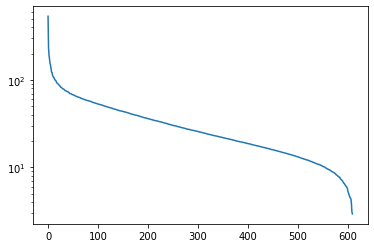

In [339]:
#Your code here
svd = np.linalg.svd(matrix, full_matrices=False)
print(svd[1])
plt.semilogy(svd[1])

(Your answer here):

In [340]:
u = np.array(svd[0])
u = np.absolute(u)
u

array([[7.04498985e-02, 2.75911949e-02, 7.84438842e-02, ...,
        2.01689548e-02, 3.54618933e-02, 6.79390545e-02],
       [3.85393459e-02, 2.06662722e-03, 5.68447103e-02, ...,
        1.33779984e-02, 1.02325253e-01, 1.27400488e-02],
       [1.59129220e-02, 2.47146155e-02, 1.80051145e-02, ...,
        1.90835186e-02, 1.19562842e-02, 2.30020847e-02],
       ...,
       [6.46836073e-05, 5.97586244e-04, 8.71093879e-05, ...,
        1.91212330e-03, 9.45491087e-04, 9.37898340e-05],
       [6.46836073e-05, 5.97586244e-04, 8.71093879e-05, ...,
        1.91212330e-03, 9.45491087e-04, 9.37898340e-05],
       [2.71729303e-04, 1.27236200e-03, 1.22833344e-04, ...,
        2.10896719e-03, 2.57733571e-03, 1.97184627e-03]])

## Question 3: Inspecting the latent concepts [25%]
Now it is time to inspect the "genres" / latent concepts. The easiest way to do so is the following: The columns of matrix $U$ correspond to our latent concepts. For each latent concept (say the $j$-th one), we can retrieve the membership of every movie to that concept. This membership vector is the $j$-th column of the $U$ matrix of the SVD. Thus, if we take the $j$-th column of U, the $i$-th value in that vector represents the degree to which the $i$-th movie "belongs" to that concept. In order to characterize the concept, we can, thus, take the top-k movies per concept, ranked in descending order by their value in that vector, and visually inspect them.

In this question, you should make a function 
```python
def print_concepts(U,num_of_concepts,top_mov):
```
which takes as input 1) the movie-to-concept matrix $U$, 2) the number of desired concepts, and 3) the number of top movies per concept, and prints the list of top movies per concept (please include title and genre).

Finally, in order to avoid negative values, take the absolute value of each entry of the above membership vector. This is a rather ad-hoc but popular choice, however, NMF directly addresses that problem by imposing non-negativity constraints in the model.


In [341]:
# takes in the movie to concept matrix, the number of desired concepts, the number of top movies per concept and outputs the top movies per concept (title and genre)
def print_concepts(U,num_of_concepts,top_mov):
    for i in range(num_of_concepts):
        print("Concept",i+1)
        print(movies.iloc[U[:,i].argsort()[-top_mov:][::-1]])
        print("\n")
            

After you've defined the "print_concepts" function, print the top-3 movies for the first 5 concepts. Do you observe coherence in the discovered latent concepts?

In [342]:
#your code here
#print the top 3 movies for the first 5 concepts
print_concepts(u,5,3)

Concept 1
      movieId                       title                       genres
314       356         Forrest Gump (1994)     Comedy|Drama|Romance|War
257       296         Pulp Fiction (1994)  Comedy|Crime|Drama|Thriller
1938     2570  Walk on the Moon, A (1999)                Drama|Romance


Concept 2
      movieId               title  \
7355    78499  Toy Story 3 (2010)   
6693    58293    10,000 BC (2008)   
7022    68522        Earth (2007)   

                                                genres  
7355  Adventure|Animation|Children|Comedy|Fantasy|IMAX  
6693                        Adventure|Romance|Thriller  
7022                                       Documentary  


Concept 3
     movieId                             title                    genres
314      356               Forrest Gump (1994)  Comedy|Drama|Romance|War
97       110                 Braveheart (1995)          Action|Drama|War
277      318  Shawshank Redemption, The (1994)               Crime|Drama


Concept 4
 

## Question 4: Running NMF and inspecting the latent concepts [25%]
In this last question, we will use the Non-negative Matrix Factorization for the same purpose. In order to run NMF, please study carefully the scikit-learn documentation: https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html 
Feel free to use existing examples for running the code.

After running NMF, use your "print_concepts" function with the same number of concepts and top movies per concept as before. Do you observe more, less, or about the same coherence in the concepts discovered?

In [343]:
#your code here
# run NMF on the matrix and print the top 3 movies for the first 5 concepts
nmf = NMF(n_components=5, init='random', random_state=0)
nmf.fit(matrix)
print_concepts(nmf.components_,5,3)

Concept 1
   movieId                    title  \
2        3  Grumpier Old Men (1995)   
1        2           Jumanji (1995)   
0        1         Toy Story (1995)   

                                        genres  
2                               Comedy|Romance  
1                   Adventure|Children|Fantasy  
0  Adventure|Animation|Children|Comedy|Fantasy  


Concept 2
   movieId                               title  \
0        1                    Toy Story (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
3                         Comedy|Drama|Romance  
4                                       Comedy  


Concept 3
   movieId                               title                genres
2        3             Grumpier Old Men (1995)        Comedy|Romance
4        5  Father of the Bride Part II (1995)                Comedy
3        